In [ ]:
#!/usr/bin/env python2
#Inspire du fichier train_fcn8.py

import os


import argparse
import time
from getpass import getuser
from distutils.dir_util import copy_tree
import pickle

import numpy as np
import random
import theano
import theano.tensor as T
import theano.tensor as tensor

from theano import gof
from theano.gof import Apply
from theano.gradient import grad_not_implemented


from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import categorical_crossentropy, aggregate

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

#from fcn_1D_general import buildFCN_1D
from metrics import jaccard, accuracy, crossentropy, weighted_crossentropy
from data_loader.cortical_layers import CorticalLayersDataset
from simple_model_1path import build_simple_model
from profile_functions import profile2indices
from itertools import product

#Stuff for profiling functions 
#os.environ['CUDA_LAUNCH_BLOCKING']='1'
#theano.config.profile= True
##theano.config.profile_memory=True
#theano.config.profile_optimizer = True

%matplotlib inline

In [4]:

class CrossentropyCategorical1HotGrad(gof.Op):

    __props__ = ()

    def make_node(self, g_y, coding_dist, true_one_of_n):
        return Apply(self, [g_y, coding_dist, true_one_of_n],
                     [coding_dist.type()])

    def perform(self, node, inp, out):
        g_y, coding_dist, true_one_of_n = inp
        g_coding_strg, = out
        g_coding = np.zeros_like(coding_dist)
        for i in xrange(len(g_y)):
            g_coding[i, true_one_of_n[i]] = (-g_y[i] /
                                             coding_dist[i, true_one_of_n[i]])
        g_coding_strg[0] = g_coding

    def infer_shape(self, node, in_shapes):
        return [in_shapes[1]]

crossentropy_categorical_1hot_grad = CrossentropyCategorical1HotGrad()


class CrossentropyCategorical1Hot(gof.Op):
    """
    Compute the cross entropy between a coding distribution and
    a true distribution of the form [0, 0, ... 0, 1, 0, ..., 0].
    .. math::
        y[i] = - \log(coding_dist[i, one_of_n[i])
    Notes
    -----
    In the case that the coding distribution is the output of a
    softmax, an application of this Op will probably be optimized
    away in favour of one with a C implementation.
    """
    __props__ = ()

    def make_node(self, coding_dist, true_one_of_n):
        """
        Parameters
        ----------
        coding_dist : dense matrix
        true_one_of_n : lvector
        Returns
        -------
        dvector
        """
        _coding_dist = tensor.as_tensor_variable(coding_dist)
        _true_one_of_n = tensor.as_tensor_variable(true_one_of_n)
        if _coding_dist.type.ndim != 2:
            raise TypeError('matrix required for argument: coding_dist')
        if _true_one_of_n.type not in (tensor.lvector, tensor.ivector):
            raise TypeError(
                'integer vector required for argument: true_one_of_n'
                '(got type: %s instead of: %s)' % (_true_one_of_n.type,
                                                   tensor.lvector))

        return Apply(self, [_coding_dist, _true_one_of_n],
                     [tensor.Tensor(dtype=_coding_dist.dtype,
                      broadcastable=[False])()])

    def perform(self, node, inp, out):
        coding, one_of_n = inp
        y_out, = out
        y = np.zeros_like(coding[:, 0])
        for i in xrange(len(y)):
            y[i] = -np.log(coding[i, one_of_n[i]])
        y_out[0] = y

    def infer_shape(self, node, in_shapes):
        return [(in_shapes[0][0],)]

    def grad(self, inp, grads):
        coding, one_of_n = inp
        g_y, = grads
        return [crossentropy_categorical_1hot_grad(g_y, coding, one_of_n),
                grad_not_implemented(self, 1, one_of_n)]

crossentropy_categorical_1hot = CrossentropyCategorical1Hot()

    
    
def categorical_crossentropy(coding_dist, true_dist):
    if true_dist.ndim == coding_dist.ndim:
        print "not using hot 1"
        return -tensor.sum(true_dist * tensor.log(coding_dist),
                           axis=coding_dist.ndim - 1)
    elif true_dist.ndim == coding_dist.ndim - 1:
        return crossentropy_categorical_1hot(coding_dist, true_dist)
    else:
        raise TypeError('rank mismatch between coding and true distributions')


In [5]:
_FLOATX = config.floatX

SAVEPATH = '/data1/data/kwagstyl/bigbrain/cortical_layers'
LOADPATH = '/data1/data/kwagstyl/bigbrain/cortical_layers'
WEIGHTS_PATH = LOADPATH

In [6]:
#Model hyperparameters
n_filters = 64
filter_size = [25]#[7,15,25,49]  
depth  = 8
data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}
block = 'bn_relu_conv'

#Training loop hyperparameters
weight_decay=0.001
num_epochs=500
max_patience=25
resume=False
learning_rate_value = 0.0005 #learning rate is defined below as a theano variable.



#Hyperparameters for the dataset loader
batch_size=[1000,1000,1]
smooth_or_raw = 'both'
shuffle_at_each_epoch = True
minibatches_subset = 0
n_layers = 6



In [7]:
#
# Prepare load/save directories
#

savepath=SAVEPATH
loadpath=LOADPATH

exp_name = 'simple_model'
exp_name += '_lrate=' + str(learning_rate_value)
exp_name += '_fil=' + str(n_filters)
exp_name += '_fsizes=' + str(filter_size)
exp_name += '_depth=' + str(depth)
exp_name += '_data=' + smooth_or_raw
exp_name += '_decay=' + str(weight_decay)
exp_name += '_pat=' + str(max_patience)
exp_name += ('_noshuffle'+str(minibatches_subset)+'batch') if not shuffle_at_each_epoch else ''
#exp_name += 'test'

dataset = str(n_layers)+'cortical_layers'
savepath = os.path.join(savepath, dataset, exp_name)
loadpath = os.path.join(loadpath, dataset, exp_name)
print 'Savepath : ' 
print savepath
print 'Loadpath : '
print loadpath

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))

print('Saving directory : ' + savepath)
with open(os.path.join(savepath, "config.txt"), "w") as f:
    for key, value in locals().items():
        f.write('{} = {}\n'.format(key, value))


Savepath : 
/data1/data/kwagstyl/bigbrain/cortical_layers/6cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
Loadpath : 
/data1/data/kwagstyl/bigbrain/cortical_layers/6cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25
 The following folder already exists /data1/data/kwagstyl/bigbrain/cortical_layers/6cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25. It will be overwritten in a few seconds...
Saving directory : /data1/data/kwagstyl/bigbrain/cortical_layers/6cortical_layers/simple_model_lrate=0.0005_fil=64_fsizes=[25]_depth=8_data=both_decay=0.001_pat=25


In [8]:
#
# Define symbolic variables
#
input_var = T.tensor3('input_var') #n_example*nb_in_channels*ray_size
target_var = T.ivector('target_var') #n_example*ray_size

learn_step=  theano.shared(np.array(learning_rate_value, dtype=theano.config.floatX))


In [9]:
#xx = np.newaxis
#def define_labels_cost(self, pred, labels0):
#        npix = T.prod(pred.shape[-2:])
#        valid = T.neq(labels0, 0)[:,xx,:,:].astype('float32')
#        labels_bin = T.eye(self.nlabels)[labels0].transpose((0,3,1,2))

        # cross entropy
#        labels_error = -T.sum(valid * labels_bin * T.log(pred)) / T.sum(valid)
#        labels_cost = labels_error#

#        return (labels_error, labels_cost)

#labels_target = T.tensor3('labels_target', dtype='uint8')
#labels_target.tag.test_value = test_values['labels']


In [10]:
Class=np.loadtxt('6layers_segmentation/training_cls.txt')

In [11]:
def compute_class_weights(Class):
    #get unique labels and number of pixels of each class
    unique, counts = np.unique(Class,return_counts=True)
    #calculate freq(c) number of pixels per class divided by the total number of pixels in images where c is present
    freq=counts.astype(float)/Class.size
    return np.median(freq)/freq

In [215]:
weights=compute_class_weights(Class)

In [234]:
#medians=np.zeros(len(unique))
#k=-1
#for label in unique:
#        k+=1
#        medians[k]=np.median((Class==label).sum(1))
_EPSILON = 10e-8

def weighted_crossentropy(y_pred, y_true, weights):
    # Clip predictions
    y_pred = T.clip(y_pred, _EPSILON, 1.0 - _EPSILON)
    #calculate crossentropy
    loss = T.nnet.categorical_crossentropy(y_pred, y_true)
  #  y_true= T.cast(y_true, 'int32')
 #   print weights[0]
    loss = loss * weights
    return loss
    
    

In [225]:
cost_train_batch, acc_train_batch, sample_acc_train_batch = train_fn(
                                                            X_train_batch, L_train_batch)

In [242]:
cost_train_batch.astype('float32')

array(0.7553266882896423, dtype=float32)

In [15]:
#
# Build dataset iterator
#

if smooth_or_raw =='both':
    nb_in_channels = 2
    use_threads = False
else:
    nb_in_channels = 1
    use_threads = True

train_iter = CorticalLayersDataset(
    which_set='train',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[0],
    data_augm_kwargs=data_augmentation,
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads,
    preload=True,
    n_layers=n_layers)

val_iter = CorticalLayersDataset(
    which_set='valid',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[1],
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads,
    preload=True,
    n_layers=n_layers)

test_iter = None



n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels


#nb_in_channels = train_iter.data_shape[0]

In [66]:
#
# Build network
#
simple_net_output, net = build_simple_model(input_var,
                    filter_size = filter_size,
                    n_filters = n_filters,
                    depth = depth,
                    block= block,
                    nb_in_channels = nb_in_channels,
                    n_classes = n_classes)

#simple_net_output = last layer of the simple_model net
#net = dictionary containing the names of every layer (used to visualize data)

# To print each layer, uncomment this:
# lays = lasagne.layers.get_all_layers(simple_net_output)
# for l in lays:
#     print l, l.output_shape
#     #print  simple_net_output[l], simple_net_output[l].output_shape, l
# print '---------------------------'
# print 'simple_net_output :', simple_net_output
# print '---------------------------'
# #print 'net :', net

In [239]:
#
# Define and compile theano functions
print "Defining and compiling training functions"

prediction = lasagne.layers.get_output(simple_net_output[0])
#loss = categorical_crossentropy(prediction, target_var)
#loss = loss * weights
#loss = loss.mean()
loss = weighted_crossentropy(prediction, target_var, weight_vector)
loss = loss.mean()

if weight_decay > 0:
    weightsl2 = regularize_network_params(
        simple_net_output, lasagne.regularization.l2)
    loss += weight_decay * weightsl2

train_acc, train_sample_acc = accuracy(prediction, target_var, void_labels)

params = lasagne.layers.get_all_params(simple_net_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=learn_step)

train_fn = theano.function([input_var, target_var, weight_vector], [loss, train_acc, train_sample_acc],
                           updates=updates)#, profile=True)

print "Done"

Defining and compiling training functions
Done


In [240]:

print "Defining and compiling valid functions"
valid_prediction = lasagne.layers.get_output(simple_net_output[0],
                                            deterministic=True)
#valid_loss = categorical_crossentropy(valid_prediction, target_var)
#valid_loss = valid_loss * weights
#valid_loss = valid_loss.mean()
weight_vector=weights[target_var]
valid_loss = weighted_crossentropy(valid_prediction, target_var, weight_vector)
valid_loss = valid_loss.mean()

#valid_loss = crossentropy(valid_prediction, target_var, void_labels)
valid_acc, valid_sample_acc = accuracy(valid_prediction, target_var, void_labels)
valid_jacc = jaccard(valid_prediction, target_var, n_classes)

valid_fn = theano.function([input_var, target_var, weight_vector],
                           [valid_loss, valid_acc, valid_sample_acc, valid_jacc])#,profile=True)
print "Done"

Defining and compiling valid functions
Done


In [19]:
#Function computing the prediction with current parameters (for visualization)
pred = theano.function([input_var], lasagne.layers.get_output(net['probs_reshape'],
                                            deterministic=True))

In [20]:
#To visualize the ray 
def make_2Darray(arr, height = 25):
    arr = np.reshape(arr, (1,arr.shape[0]))
    x = np.repeat(arr, height, 0)
    return x


In [21]:
def plot_true_predicted_labels(X_batch, L_batch, idx_batch, smooth_or_raw='raw', index = -1, which_set=''):
    #Get random sample
    if index != -1:
        idx = index
    else:
        idx = random.randint(0,X_batch.shape[0]-1)
    
    real_idx = idx_batch[idx]

    ray = X_batch[idx][0]
    true_labels = L_batch[idx*200:(idx+1)*200]
    predicted_labels = np.argmax(pred(X_batch), axis=2)[idx]

    true_vs_predicted = np.concatenate((make_2Darray(true_labels),
                                        make_2Darray(predicted_labels)), axis = 0)

    
    if smooth_or_raw=='both':
        plt.title('Smooth vs raw data ' + which_set + ' idx = '+ str(real_idx))
        data = np.concatenate((make_2Darray(X_batch[idx][0]),
                                   make_2Darray(X_batch[idx][1])), axis=0)
        plt.imshow(data, cmap='gray', interpolation='none')
        plt.figure()
    else : 
        plt.title(smooth_or_raw + ' data ' + which_set + ' idx = '+ str(real_idx))
        plt.imshow(make_2Darray(X_batch[idx][0]), cmap='gray', interpolation='none')
        plt.figure()
        

    
    plt.title('Ground truth vs predicted labels '+ which_set + ' idx = '+ str(real_idx))
    plt.imshow(true_vs_predicted, interpolation='none', vmin=0, vmax=n_classes)
    plt.figure()

    plt.show()

In [22]:
def index_worse_than(sample_acc_batch,  idx_batch, treshold=0.7):
    
    worse_batch_idx = np.array([i for i in range(len(sample_acc_batch)) if sample_acc_batch[i]<treshold], dtype=int)
    if worse_batch_idx==[]:
        return []
    else :
        return idx_batch[worse_batch_idx]
    
    

In [232]:
# Uncomment this if only 1 minibatch (smaller dataset)
# and comment 2 lines in training loop to avoid getting new minibatches
# train_batch = train_iter.next()
# X_train_batch, L_train_batch, idx_train_batch = train_batch['data'], train_batch['labels'], train_batch['indices'][0]

# val_batch = val_iter.next()
# X_val_batch, L_val_batch, idx_val_batch = val_batch['data'], val_batch['labels'], val_batch['indices'][0]

minibatches_subset = 1

# print X_train_batch.shape
# print L_train_batch.shapedata






189800

In [24]:
#whether to plot labels prediction or not during training 
#(1 random example of the last minibatch for each epoch)
plot_results_train = True #from the training set
plot_results_valid = True #from the validation set

treshold = 0.7 # for extracting the very incorrect labelled samples
ratios=[0.80,0.85, 0.90] #ratios for the per sample accuracy

In [237]:
# Training main loop

err_train = []
acc_train = []
sample_acc_train_tot = []
worse_indices_train = []
already_seen_idx = []

err_valid = []
acc_valid = []
jacc_valid = []
sample_acc_valid_tot = []
patience = 0
worse_indices_valid =[]


print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))

    # Single epoch training and validation
    start_time = time.time()
    #Cost train and acc train for this epoch
    cost_train_epoch = 0
    acc_train_epoch = 0
    sample_acc_train_epoch = np.array([0.0 for i in range(len(ratios))])
    worse_indices_train_epoch = []




    for i in range(n_batches_train):
        # Get minibatch (comment the next line if only 1 minibatch in training)
        train_batch = train_iter.next()
        X_train_batch, L_train_batch = train_batch['data'], train_batch['labels']#, train_batch['indices'][0]

        L_train_batch = np.reshape(L_train_batch, np.prod(L_train_batch.shape))

        # Training step
        cost_train_batch, acc_train_batch, sample_acc_train_batch = train_fn(
                                                            X_train_batch, L_train_batch)
        sample_acc_train_batch_mean = [np.mean([(i>=ratio)
                                for i in sample_acc_train_batch]) for ratio in ratios]

#        worse_indices_train_batch = index_worse_than(sample_acc_train_batch,
 #                                          idx_train_batch, treshold=treshold)


        #print i, 'training batch cost : ', cost_train_batch, ' batch accuracy : ', acc_train_batch

        #Update epoch results
        cost_train_epoch += cost_train_batch
        acc_train_epoch += acc_train_batch
        sample_acc_train_epoch += sample_acc_train_batch_mean
  #      worse_indices_train_epoch = np.hstack((worse_indices_train_epoch,worse_indices_train_batch))

    #Add epoch results
    err_train += [cost_train_epoch/n_batches_train]
    acc_train += [acc_train_epoch/n_batches_train]
    sample_acc_train_tot += [sample_acc_train_epoch/n_batches_train]
   # worse_indices_train += [worse_indices_train_epoch]

    #if plot_results_train: #select random example from the last minibatch and plot it
     #   plot_true_predicted_labels(X_train_batch, L_train_batch, idx_train_batch, smooth_or_raw,which_set='TRAINING')
    
    
    
    # Validation
    cost_val_epoch = 0
    acc_val_epoch = 0
    sample_acc_valid_epoch = np.array([0.0 for i in range(len(ratios))])
    jacc_val_epoch = np.zeros((2, n_classes))
    worse_indices_val_epoch = []


    for i in range(n_batches_val):

        # Get minibatch (comment the next line if only 1 minibatch in training)
        val_batch = val_iter.next()
        X_val_batch, L_val_batch = val_batch['data'], val_batch['labels']#, val_batch['indices'][0]

        L_val_batch = np.reshape(L_val_batch, np.prod(L_val_batch.shape))

        weight_vector=weights[L_val_batch]
        # Validation step
        cost_val_batch, acc_val_batch, sample_acc_valid_batch, jacc_val_batch = valid_fn(X_val_batch, L_val_batch)
        #print i, 'validation batch cost : ', cost_val_batch, ' batch accuracy : ', acc_val_batch


        sample_acc_valid_batch_mean = [np.mean([(i>=ratio)
                                for i in sample_acc_valid_batch]) for ratio in ratios]



        #Update epoch results
        cost_val_epoch += cost_val_batch
        acc_val_epoch += acc_val_batch
        sample_acc_valid_epoch += sample_acc_valid_batch_mean
        jacc_val_epoch += jacc_val_batch
      #  worse_indices_val_epoch = np.hstack((worse_indices_val_epoch, worse_indices_val_batch))
        #
        
  #  if plot_results_valid: #select random example from the last minibatch and plot it
  #      plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, index=worst_index, which_set='VALIDATION WORST')
  #      plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, which_set='VALIDATION')


    #Add epoch results
    err_valid += [cost_val_epoch/n_batches_val]
    acc_valid += [acc_val_epoch/n_batches_val]
    sample_acc_valid_tot += [sample_acc_valid_epoch/n_batches_val]
    jacc_perclass_valid = jacc_val_epoch[0, :] / jacc_val_epoch[1, :]
    jacc_valid += [np.mean(jacc_perclass_valid)]
    # worse_indices_valid += [worse_indices_val_epoch]


    #Print results (once per epoch)

    out_str = "EPOCH %i: Avg cost train %f, acc train %f"+        ", cost val %f, acc val %f, jacc val %f took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         acc_train[epoch],
                         err_valid[epoch],
                         acc_valid[epoch],
                         jacc_valid[epoch],
                         time.time()-start_time)
    out_str2 = 'Per sample accuracy (ratios ' + str(ratios) + ') '
    out_str2 += ' train ' +str(sample_acc_train_tot[epoch])
    out_str2 += ' valid ' + str(sample_acc_valid_tot[epoch])
    print out_str
    print out_str2



    # Early stopping and saving stuff

    with open(os.path.join(savepath, "fcn1D_output.log"), "a") as f:
        f.write(out_str + "\n")

    if epoch == 0:
        best_jacc_val = jacc_valid[epoch]
    elif epoch > 1 and jacc_valid[epoch] > best_jacc_val:
        print('saving best (and last) model')
        best_jacc_val = jacc_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'new_fcn1D_model_best.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_best.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    # Finish training if patience has expired or max nber of epochs reached

    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break


Start training
EPOCH 0: Avg cost train 1.176699, acc train 0.771601, cost val 0.287796, acc val 0.805060, jacc val 0.615862 took 275.094276 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.47794788  0.18848923  0.01249617] valid [ 0.61538685  0.28153865  0.02159395]
EPOCH 1: Avg cost train 0.991793, acc train 0.816672, cost val 0.254558, acc val 0.827508, jacc val 0.652506 took 276.530341 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.68615333  0.35710949  0.03149578] valid [ 0.7391566   0.43341492  0.04437319]
saving last model
EPOCH 2: Avg cost train 0.878588, acc train 0.831359, cost val 0.238860, acc val 0.835665, jacc val 0.666708 took 204.214467 s
Per sample accuracy (ratios [0.8, 0.85, 0.9])  train [ 0.76667489  0.46069453  0.0513534 ] valid [ 0.78423714  0.48257986  0.0613615 ]
saving best (and last) model


KeyboardInterrupt: 

In [29]:
Indices=[]
for a in A['indices'][0]:
    Indices.append(int(a[0,0]))


In [41]:
def convert2indices(AA):
    Indices=[]
    for a in AA[-1]:
        Indices.append(int(a[0,0]))
    return np.array(Indices)

In [20]:
#
# Train loop
#
err_train = []
acc_train = []
sample_acc_train_tot = []
worse_indices_train = []
already_seen_idx = []

err_valid = []
acc_valid = []
jacc_valid = []
sample_acc_valid_tot = []
patience = 0
worse_indices_valid =[]



# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))
    
    # Single epoch training and validation
    start_time = time.time()
    #Cost train and acc train for this epoch
    cost_train_epoch = 0
    acc_train_epoch = 0
    sample_acc_train_epoch = np.array([0.0 for i in range(len(ratios))])
    worse_indices_train_epoch = []

    # Train
    if minibatches_subset > 0:
        n_batches_val = minibatches_subset
        n_batches_train = minibatches_subset
        
        
    for i in range(n_batches_train):
        # Get minibatch (comment the next line if only 1 minibatch in training)
        train_batch = train_iter.next()
        X_train_batch, L_train_batch, idx_train_batch = train_batch['data'], train_batch['labels'], convert2indices(train_batch['indices'])

        L_train_batch = np.reshape(L_train_batch, np.prod(L_train_batch.shape))
        
        # Training step
        cost_train_batch, acc_train_batch, sample_acc_train_batch = train_fn(
                                                            X_train_batch, L_train_batch)
        sample_acc_train_batch_mean = [np.mean([(i>=ratio) 
                                for i in sample_acc_train_batch]) for ratio in ratios]
        
        worse_indices_train_batch = index_worse_than(sample_acc_train_batch, 
                                          idx_train_batch, treshold=treshold)
        

        #print i, 'training batch cost : ', cost_train_batch, ' batch accuracy : ', acc_train_batch

        #Update epoch results    
        cost_train_epoch += cost_train_batch
        acc_train_epoch += acc_train_batch
        sample_acc_train_epoch += sample_acc_train_batch_mean
        worse_indices_train_epoch = np.hstack((worse_indices_train_epoch,worse_indices_train_batch))
        
    #Add epoch results    
    err_train += [cost_train_epoch/n_batches_train]
    acc_train += [acc_train_epoch/n_batches_train]
    sample_acc_train_tot += [sample_acc_train_epoch/n_batches_train]
    worse_indices_train += [worse_indices_train_epoch]
    
    if plot_results_train: #select random example from the last minibatch and plot it
        plot_true_predicted_labels(X_train_batch, L_train_batch, idx_train_batch, smooth_or_raw,which_set='TRAINING')
    

    # Validation
    cost_val_epoch = 0
    acc_val_epoch = 0
    sample_acc_valid_epoch = np.array([0.0 for i in range(len(ratios))])
    jacc_val_epoch = np.zeros((2, n_classes))
    worse_indices_val_epoch = []


    for i in range(n_batches_val):
        
        # Get minibatch (comment the next line if only 1 minibatch in training)
        val_batch = val_iter.next()
        X_val_batch, L_val_batch, idx_val_batch = val_batch['data'], val_batch['labels'], convert2indices(val_batch['indices'])

        L_val_batch = np.reshape(L_val_batch, np.prod(L_val_batch.shape))
        

        # Validation step
        cost_val_batch, acc_val_batch, sample_acc_valid_batch, jacc_val_batch = valid_fn(X_val_batch, L_val_batch)
        #print i, 'validation batch cost : ', cost_val_batch, ' batch accuracy : ', acc_val_batch
        worst_index = np.argmin(sample_acc_valid_batch)
        
        
        sample_acc_valid_batch_mean = [np.mean([(i>=ratio) 
                                for i in sample_acc_valid_batch]) for ratio in ratios]
        
        worse_indices_val_batch = index_worse_than(sample_acc_valid_batch, 
                                          idx_val_batch, treshold=treshold)
        


        #Update epoch results
        cost_val_epoch += cost_val_batch
        acc_val_epoch += acc_val_batch
        sample_acc_valid_epoch += sample_acc_valid_batch_mean
        jacc_val_epoch += jacc_val_batch
        worse_indices_val_epoch = np.hstack((worse_indices_val_epoch, worse_indices_val_batch))
        
    
    if plot_results_valid: #select random example from the last minibatch and plot it
        plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, index=worst_index, which_set='VALIDATION WORST')
        plot_true_predicted_labels(X_val_batch, L_val_batch, idx_val_batch, smooth_or_raw, which_set='VALIDATION')

    #Add epoch results 
    err_valid += [cost_val_epoch/n_batches_val]
    acc_valid += [acc_val_epoch/n_batches_val]
    sample_acc_valid_tot += [sample_acc_valid_epoch/n_batches_val]
    jacc_perclass_valid = jacc_val_epoch[0, :] / jacc_val_epoch[1, :]
    jacc_valid += [np.mean(jacc_perclass_valid)]
    worse_indices_valid += [worse_indices_val_epoch]
    

    #Print results (once per epoch)
    
    out_str = "EPOCH %i: Avg cost train %f, acc train %f"+\
        ", cost val %f, acc val %f, jacc val %f took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         acc_train[epoch],
                         err_valid[epoch],
                         acc_valid[epoch],
                         jacc_valid[epoch],
                         time.time()-start_time)
    out_str2 = 'Per sample accuracy (ratios ' + str(ratios) + ') '
    out_str2 += ' train ' +str(sample_acc_train_tot[epoch]) 
    out_str2 += ' valid ' + str(sample_acc_valid_tot[epoch])
    print out_str
    print out_str2

    

    # Early stopping and saving stuff
    
    with open(os.path.join(savepath, "fcn1D_output.log"), "a") as f:
        f.write(out_str + "\n")
        
    if epoch == 0:
        best_jacc_val = jacc_valid[epoch]
    elif epoch > 1 and jacc_valid[epoch] > best_jacc_val:
        print('saving best (and last) model')
        best_jacc_val = jacc_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'new_fcn1D_model_best.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_best.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid, jacc_valid=jacc_valid)
    # Finish training if patience has expired or max nber of epochs reached

    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break 




Start training


NameError: name 'convert2indices' is not defined

In [40]:
val_batch['indices']

array([[None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)],
       [None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)],
       [None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)],
       ..., 
       [None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)],
       [None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)],
       [None, None, None, ..., (('default', 19408),),
        (('default', 19412),), (('default', 19432),)]], dtype=object)

In [30]:
worse_train = np.sort(worse_indices_train[3])
for i in worse_train:
    print int(i)

265
267
268
269
270
272
274
276
277
278
279
281
283
284
285
290
292
295
297
299
301
305
307
309
312
320
321
323
327
328
332
333
336
338
341
342
344
347
348
349
350
351
352
353
354
355
356
359
361
362
363
364
365
366
371
372
376
384
388
401
410
411
415
418
1589
1651
1661
1663
2833
3075
3079
3082
3083
3085
3086
3087
3088
3092
3100
3103
3104
3105
3109
3111
3114
3115
3116
3119
3120
3123
3129
3139
3144
3146
3147
3151
3156
3157
3160
3161
3162
3163
3164
3165
3168
3169
3170
3174
3175
3176
3177
3180
3181
3183
3184
3185
3188
3193
3195
3211
3241
3247
3249
3273
3275
3276
3286
3288
3290
3291
3315
3341
3415
3482
3594
3673
5531
5536
5538
5572
5629
8147
8560
8564
8577
8592
8595
8596
8598
8599
9642
9645
9646
9661
9677
9678
9691
9705
9707
9719
9721
9723
9732
9736
10630
11221
11227
11241
11242
11247
11271
12901
13011
15282
15458
15460
15466
15467
15468
15470
15472
15473
15474
15475
15476
15477
15478
15479
17700
17707
17718
17722
17852
17865
17866
17880
17918
17961
20258
20285
20314
20319
20324
20340
2034

In [31]:
worse_valid = np.sort(worse_indices_valid[3])
for i in worse_valid:
    print int(i)

266
291
296
298
311
319
324
326
335
337
339
340
346
360
373
382
3126
3127
3130
3152
3154
3158
3159
3179
3186
3321
3363
3650
9657
9701
10635
15469
15471
17699
17701
17740
17764
17864
17963
20337
20358
20400
20405
20454
20455
20459
20462
20485
20494
20549
20570
20585
20615
20618
20646
20655
20669
20673
20810
20811
20822
20824
20827
20843
20863
20866
20869
20896
20930
20962
24014
24073
24242
28045
30663
30679
30683
30705
31374
31376
31383
31396
31397
31404
31408
31414
33432
38053
40462
40919
41459
42177
42188
42487
42521
42528
43630
44300
44321
44360
44364
45083
45354
46566
47082
47128
47322
48270
48275
48285
48294
48299
48301
48306
48321
48368
48372
48373
48663
52095
52099
52104
52108
52114
52123
57352
57382
59480
59481
59486
72858
74575
74970
74988
75002
75182
75225
75231
75233
75239
75249
75256
75263
75268
75272
75285
75317
75360
75366
75894
75896
75903
76214
76309
76798
77008
77013
77015
77567
77580
77583
77591
77601
77630
77712
77719


In [22]:

#####################################################################################
# Stuff for computational graphs and profiling functions (to analyse theano behavior)
#####################################################################################

# with open('/u/larocste/cortical_layers/train_fct_debugprint_stephanie.txt', 'w') as save_file:
#     theano.printing.debugprint(train_fn, file=save_file)

# train_fn.profile.summary()

# with open('/u/larocste/cortical_layers/test_fct_debugprint_stephanie.txt', 'w') as save_file:
#     theano.printing.debugprint(valid_fn, file=save_file)

# valid_fn.profile.summary()



In [23]:
def show_feature_maps(net, layers_name, subset=25, type = 'grayscale'):
    #Show feature maps for the net's layers_name in grayscale or regular plot
    #(example below)
    
    p = lasagne.layers.get_all_param_values(net[layers_name])
    nb = min(subset, p[0].shape[0])
    if type =='grayscale':
        for i in range(subset):
            plt.imshow(make_2Darray(p[0][i, 0, :], height = 5), cmap='gray')
            plt.figure()
    elif type =='regular':
        for i in range(subset):
            plt.plot(p[0][i, 0, :])
            plt.show()
        

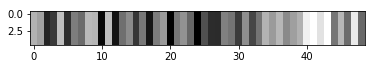

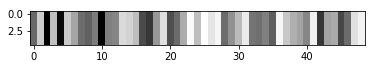

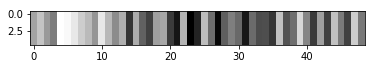

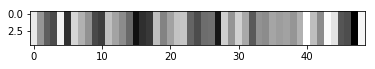

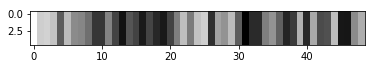

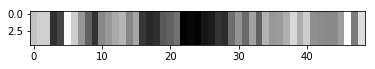

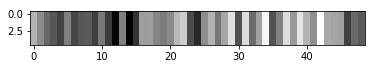

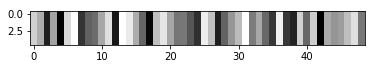

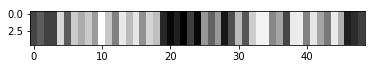

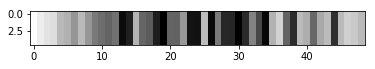

In [24]:
show_feature_maps(net, layers_name = 'relu3_3',subset=10, type='grayscale')

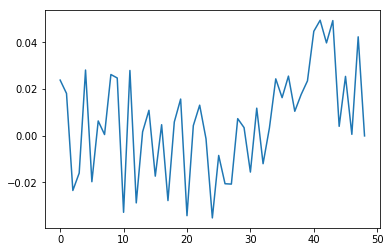

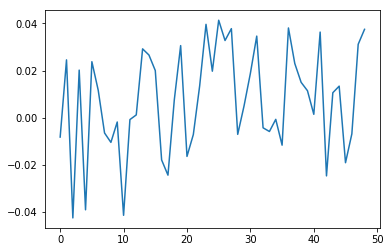

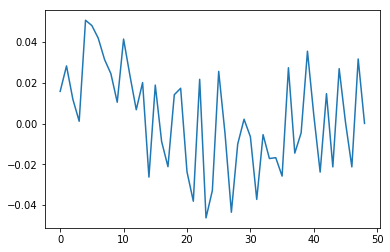

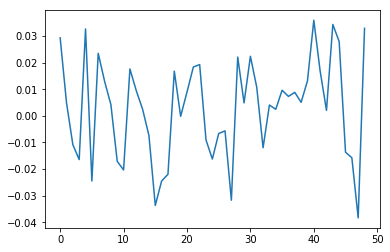

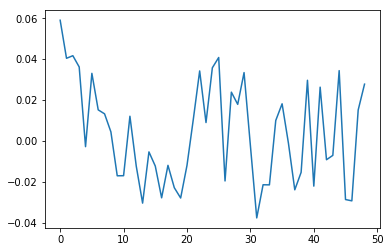

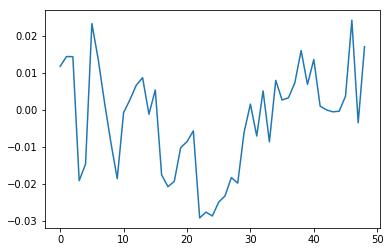

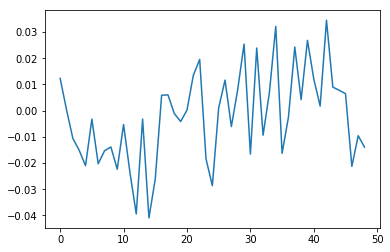

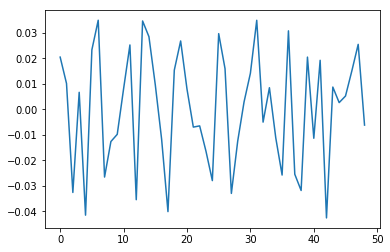

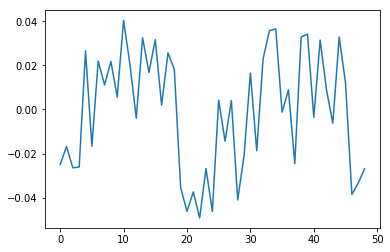

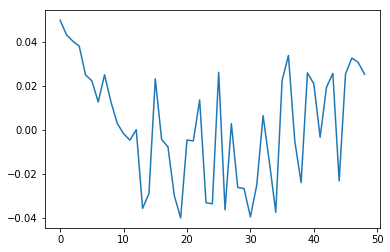

In [25]:
show_feature_maps(net, 'relu3_3',subset =10, type='regular')

In [32]:
def plot_error_acc_curves(err_train = err_train, err_valid = err_valid,
                    acc_train = acc_train, acc_valid=acc_valid, jacc_valid =jacc_valid):
    plt.title('Cost error')
    plt.plot(err_train, 'blue', label='cost train')
    plt.plot(err_valid, 'orange', label='cost valid')
    #plt.ylim((0,2))
    plt.legend()
    plt.figure()
    
    plt.title('Accuracy')
    plt.plot(acc_train, 'blue', label='acc train')
    plt.plot(acc_valid, 'orange', label='acc valid')
    plt.plot(jacc_valid, 'green', label='jaccard valid')
    plt.legend()
    
    
    
    

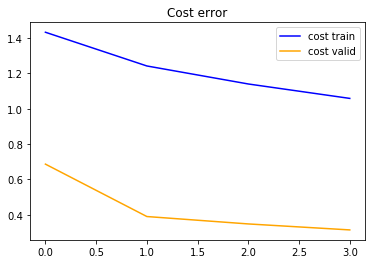

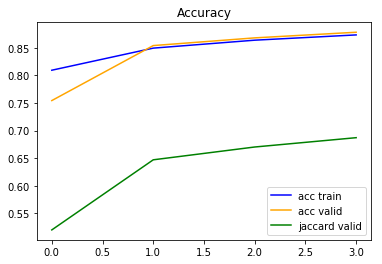

In [33]:
plot_error_acc_curves()

## Ground truth labels colors :

- Purple : label 0 (padding)
- Purple/blue : label 1 (layers 1)
- blue : label 2 (layer 2-3)
- turkoise : label 3 (layers 4 ... almost never present in the predicted labels)
- green : label 4 (layer 5-6)
- yellow : label 5 (nonsense)

### Thoughts after version 2

- Batch normalization (BN) helped a lot with the accuracy. 25% to 80% accuracy by adding BN to each convlayer
- Label 3 seems really hard to predict. Often predicted as label 4 
    - true labels distribution (per class) [4607, 1539, 5637, 976, 6041, 1200]
    - pred labels distribution (per class) [4980, 1470, 6702, 0, 6188, 660]
- Can't learn (yet) the nonsense label
- Learning rate 0.005 seems too big --lot of fluctuations in the cost error (0.001 seems fine, maybe lower could be good too)

### Thoughts after version 3

- Can now achieve 93-95% training accuracy, 90-91% validation accuracy
- Can now predict class 3 and nonsense labels (better than in version 2)

- Per sample accuracy as early stopping criterion? 
- Use raw+smooth? (instead of just raw)
- Try to simplify the model (simpler the better)

### Thoughts after version 4

- Using raw+smooth (i.e. 2 in_channels) requires use_threads=False. If set to True, each epoch takes ~500sec instead of ~300sec. Back to ~300sec when set to False. When only 1 in_channel, what is faster? (Does it change something).

## Best hyper-parameters so far

- n_filters = 64
- filter_size = [7, 15, 25, 49]
- depth = 4
- weight_decay = 0.001
- num epochs max = 500
- max patience = 25
- learning rate initial value = 0.0005
- smooth or raw ? raw
- batch size = [500, 500, 1]
- shuffle at each epoch ? True n_subset = 0


### Achieves

- Training cost : 0.22
- Validation cost : 0.23

- Training accuracy (per pixel) : 94.1%
- Validation accuracy (per pixel) : 91.4%
- Validation jaccard accuracy : 80.6%

## Better hyperparameters have been found (in terms of % of the sample that achives >90%)